In [1]:
import os
import json
import numpy as np

import torch

from dataset import data_transform
from utils import DotDict, Logger, bias, denormalize_data, rel_error, rmse
from sp_att_mech import AttentionCNN

import matplotlib.pyplot as plt
%matplotlib inline

# DATA IMPORTATION AND VISUALIZATION

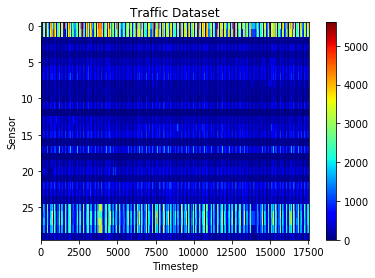

In [2]:
datadir = 'data'
dataset = 'sp_data.csv'
data = torch.Tensor(np.genfromtxt(os.path.join('..',datadir, dataset)))

plt.figure('Traffic Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Traffic Dataset')
plt.xlabel('Timestep')
plt.ylabel('Sensor')
plt.colorbar()

# TRAINING AND TEST ERROR METRICS
 - Additional parameters via --parameter_name value
 - For simplicity, 60%-20%-20% validation scheme (training-validation-test)

In [3]:
 run training.py

 36%|███▋      | 73/200 [01:15<02:01,  1.05it/s, lr=0.0001, train_mse=0.0145, train_rmse=0.121, val_mse=0.0142, val_rmse=0.119]



 *  Test MSE:  96792.6171875 
 *  Test RMSE:  311.115118866795 
 *  Test Bias:  -35.57925796508789 
 *  Test Rel-Err (%):  28.562769293785095



<Figure size 432x288 with 0 Axes>

# RESULTS
 - Example: mean prediction from 00:00 to 23:00
 - Learning curve
 - Error distribution: spatial and temporal

In [4]:
outputdir  = opt.outputdir
with open(os.path.join(outputdir, 'logs.json'), 'r') as f:
    logs = json.load(f)
    
with open(os.path.join(outputdir, 'config.json'), 'r') as f:
    config = json.load(f)

opt = DotDict(config)

In [5]:
model = AttentionCNN(in_channels=opt.n_inp, out_channels=opt.n_out, 
                     dim_x=opt.dim_x, dim_y=opt.dim_y)
model.to(device)
model.load_state_dict(torch.load(os.path.join(outputdir, 'spatial_model.pth')))

<All keys matched successfully>

In [6]:


_, _, _, _, X_test, Y_test, min_value, max_value = data_transform(opt)

test_dataset = []
for i in range(len(X_test)):
   test_dataset.append([X_test[i], Y_test[i]]) 
    
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = len(X_test),
                                           shuffle = False)

In [7]:
model.eval()
with torch.no_grad():        
    for x,y in test_loader:
        if torch.cuda.is_available():
            x = x.to(device)
            y = y.to(device)
        else:
            x = x
            y = y
        y_pred, _ = model(x)
        
        y_pred_dnorm = denormalize_data(y_pred.view(-1, opt.n_inp, opt.n_points).cpu(), min_value, max_value)
        y_dnorm = denormalize_data(y.view(-1, opt.n_inp, opt.n_points).cpu(), min_value, max_value)

y_tstep = y_dnorm[16::24]
y_pred_tstep = y_pred_dnorm[16::24]

## Example

Text(0.5, 1.0, 'Absolute error')

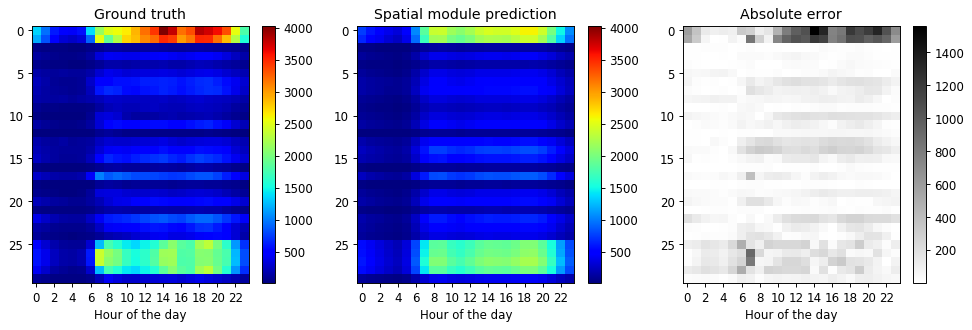

In [8]:
real = y_tstep.mean(0)
prediction = y_pred_tstep.mean(0)

plt.figure('Example', figsize=(14, 4), dpi=85)

plt.subplot(1, 3, 1)
plt.imshow(real.T,  vmin = real.min(), vmax = real.max(), aspect='auto', cmap='jet')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Ground truth')

plt.subplot(1, 3, 2)
plt.imshow(prediction.T,  vmin = real.min(), vmax = real.max(), aspect='auto', cmap='jet')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Spatial module prediction')

plt.subplot(1, 3, 3)
plt.imshow(real.sub(prediction).abs().T, aspect='auto', cmap='gray_r')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Absolute error')

## Learning curve

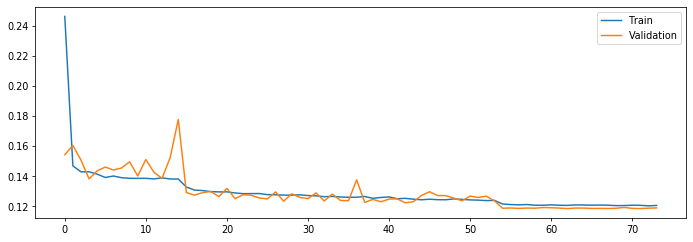

In [9]:
plt.figure('Error', figsize=(12, 4), dpi=70)
plt.plot(np.sqrt(logs['train.mse']), label = 'Train')
plt.plot(np.sqrt(logs['val.mse']), label = 'Validation')
plt.legend()

## Temporal RMSE distribution: hour

Text(0.5, 0, 'Hour of the day')

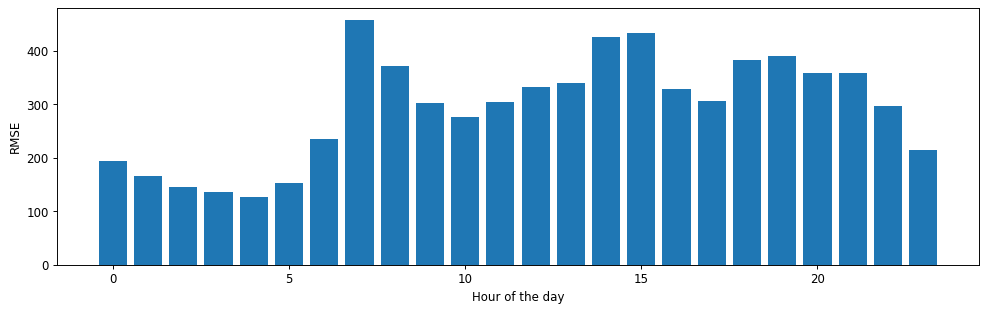

In [10]:
plt.figure('RMSE dist hour', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_tstep,y_tstep, dim=2))
plt.ylabel('RMSE')
plt.xlabel('Hour of the day')

## Temporal RMSE distribution: timestep

Text(0.5, 0, 'Timestep')

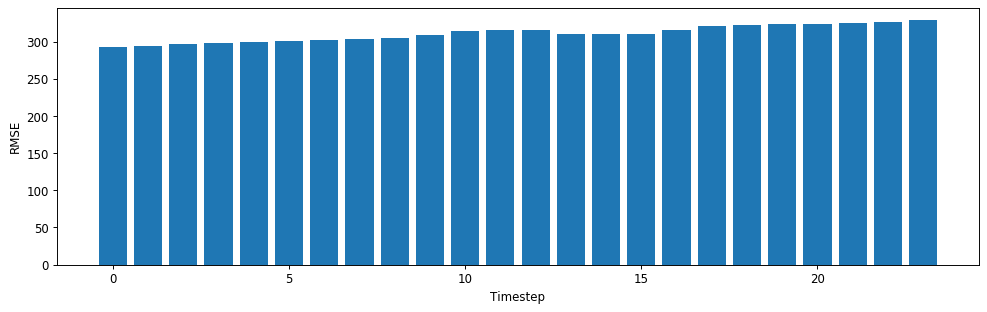

In [11]:
plt.figure('RMSE dist timestep', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_dnorm, y_dnorm, dim=2))
plt.ylabel('RMSE')
plt.xlabel('Timestep')

## Spatial RMSE distribution

Text(0.5, 0, 'Sensor')

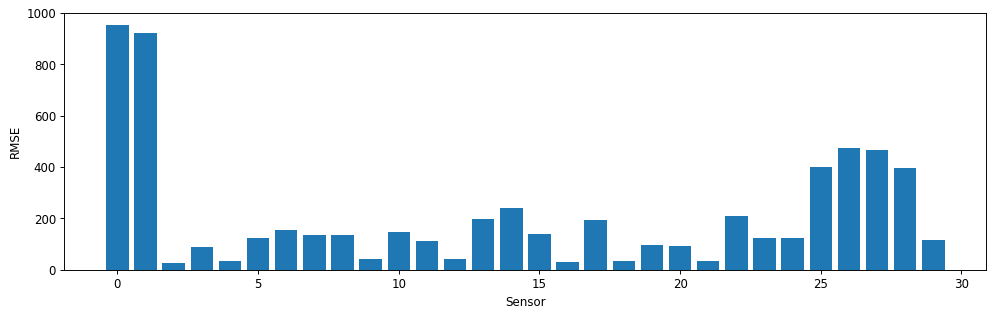

In [12]:
plt.figure('RMSE dist spatial', figsize=(14, 4), dpi=85)
plt.bar(x = np.arange(0,30),height = rmse(y_pred_dnorm,y_dnorm, dim=1))
plt.ylabel('RMSE')
plt.xlabel('Sensor')